In [8]:
# 데이터셋과 학습된 모델을 저장할 폴더 생성
!mkdir images
!mkdir models
!mkdir logs

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘models’: File exists


In [9]:
# ! pip install -U tensorflow
# ! pip install tensorflow-model-optimization
# ! pip install --upgrade grpcio

# 필요한 라이브러리 불러오기
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
import seaborn as sns
import tempfile
import tensorboard
import tensorflow as tf
import timeit
import zipfile

from IPython.core.pylabtools import figsize
from numpy import linalg as LA
from tensorflow.keras.models import load_model
from tensorflow_model_optimization.sparsity import keras as sparsity

# Tensorflow 버전 확인
print(tf.__version__)

plt.style.use('fivethirtyeight')
sns.set_context('notebook')
pd.set_option('display.max_rows', 30)
np.random.seed(1337)
%config InlineBackend.figure_format = 'retina'
%load_ext tensorboard

2.2.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
# MNIST와 Fashion-MNIST 데이터셋 다운로드 / 불러오기 함수
def load_dataset(dataset='mnist'):
    """
    Loads and preprocesses the data for this task.
    Args:
      dataset: the name of the dataset to be used for this classification task.
        (mnist | fmnist)
    Returns:
      x_train: Features for training data 
      x_test: Features for test data
      y_train: Labels for training data
      y_test: Labels for test data
      num_classes: Number of classes for the dataset
    """
    # 학습 이미지 사이즈 (28, 28, 1) / MNIST와 Fashion-MNIST 이미지 사이즈는 동일
    img_rows, img_cols = 28, 28
    
    if dataset=='mnist':
        # MNIST 데이터셋 클래스 갯수
        num_classes = 10
        
        # MNIST 데이터셋 불러오기 / Training과 Test 셋 분리 후 셔플
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    elif dataset=='fmnist':
        # Fashion-MNIST 데이터셋 클래스 갯수
        num_classes = 10
        
        # Fashion-MNIST 데이터셋 불러오기 / Training과 Test 셋 분리 후 셔플
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        
    else:
        print('dataset name does not match available options \n( mnist | keras )')

    x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
    input_shape = (img_rows*img_cols*1,)

    # 이미지 타입 전환 / 정규화
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # 데이터셋 클래스를 Vector로 전환
    # e.g. [0, 1, 2] --> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, x_test, y_train, y_test, num_classes, input_shape


# MNIST 데이터셋 정의
mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test, num_classes, input_shape = load_dataset(dataset='mnist')

# Fashion-MNIST 데이터셋 정의
fmnist_x_train, fmnist_x_test, fmnist_y_train, fmnist_y_test, num_classes, input_shape = load_dataset(dataset='fmnist')

x_train shape: (60000, 784)
60000 train samples
10000 test samples
x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [11]:
# 계층 모듈 정의 (e.g. Fully-connected layer, CNN, RNN etc.)
l = tf.keras.layers

# 심층 학습 모델 빌드 함수
def build_model_arch(input_shape, num_classes, sparsity=0.0):
    """
    Builds the model architecture
    Args:
      input_shape: The tuple describing the input shape
      num_classes: how many classes the data labels belong to
      sparsity: For compressing already sparse models, how much sparsity was used
    Returns:
      model: an un-compiled TF.Keras model with 4 hidden
        dense layers with shapes [1000, 1000, 500, 200]      
    """

    model = tf.keras.Sequential()

    # 5 Fully-connected layer with ReLU function 정의
    # 한개의 클래스의 Probability를 최대화 하기위해서 마지막 단에 Softmax function 사용
    model.add(l.Dense(int(1000-(1000*sparsity)), activation='relu',
                      input_shape=input_shape)),
    model.add(l.Dense(int(1000-(1000*sparsity)), activation='relu'))
    model.add(l.Dense(int(500-(500*sparsity)), activation='relu'))
    model.add(l.Dense(int(200-(200*sparsity)), activation='relu'))
    model.add(l.Dense(num_classes, activation='softmax'))

    return model

# MNIST와 Fashion-MNIST 모델 빌드 (Sparsity == 0.0)
mnist_model_base = build_model_arch(input_shape, num_classes)
fmnist_model_base = build_model_arch(input_shape, num_classes)

In [12]:
# Log 파일 생성
logdir = './logs'
print('Writing training logs to ' + logdir)

Writing training logs to ./logs


In [13]:
# 심층 학습 모델 학습 함수
def make_nosparse_model(model, x_train, y_train, batch_size, epochs, x_test, y_test):
    """
    Training our original model, pre-pruning
    Args:
      model: Uncompiled Keras model
      x_train: Features for training data 
      y_train: Labels for training data
      batch_size: Batch size for training
      epochs: Number of epochs for training
      x_test: Features for test data
      y_test: Labels for test data
    Returns:
      model: compiled model
      score: List of both final test loss and final test accuracy
    """
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]

    # 심층 학습 모델 컴파일 
    # Loss function: Cross entropy loss
    # Optimizer: Adam optimizer
    # Measure: Accuracy

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['accuracy'])

    # 심층 학습 모델 학습
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_test, y_test))
    
    # 심층 학습 모델 평가
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model, score

batch_size = 128
epochs = 10

mnist_model, mnist_score = make_nosparse_model(mnist_model_base,
                                               mnist_x_train,
                                               mnist_y_train,
                                               batch_size,
                                               epochs,
                                               mnist_x_test,
                                               mnist_y_test)
print(mnist_model.summary())

fmnist_model, fmnist_score = make_nosparse_model(fmnist_model_base,
                                                 fmnist_x_train,
                                                 fmnist_y_train,
                                                 batch_size,
                                                 epochs,
                                                 fmnist_x_test,
                                                 fmnist_y_test)

print(fmnist_model.summary())

469/469 [==============================] - 4s 8ms/step - loss: 0.2090 - accuracy: 0.9368 - val_loss: 0.1133 - val_accuracy: 0.9661
Test loss: 0.11331934481859207
Test accuracy: 0.9660999774932861
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_12 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_13 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2010      
Total params: 2,388,710
Trainable params: 2,388,710
Non-

In [15]:
# Tensorboard 실행
%tensorboard --logdir={logdir}

In [16]:
# Pruning 함수 (Weight)
def weight_prune_dense_layer(k_weights, b_weights, k_sparsity):
    """
    Takes in matrices of kernel and bias weights (for a dense
      layer) and returns the unit-pruned versions of each
    Args:
      k_weights: 2D matrix of the 
      b_weights: 1D matrix of the biases of a dense layer
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights: sparse matrix with same shape as the original
        kernel weight matrix
      bias_weights: sparse array with same shape as the original
        bias array
    """

    # Kernel weights 복사
    kernel_weights = np.copy(k_weights)

    # Weight의 절대값을 기준으로 인덱스 정렬 (2D martix)
    ind = np.unravel_index(
        np.argsort(
            np.abs(kernel_weights),
            axis=None),
        kernel_weights.shape)
        
    # Pruning 하는 Weights 갯수 정의
    cutoff = int(len(ind[0])*k_sparsity)

    # 정렬된 인덱스를 기준으로 Weight pruning 수행 (0)
    sparse_cutoff_inds = (ind[0][0:cutoff], ind[1][0:cutoff])
    kernel_weights[sparse_cutoff_inds] = 0.
        
    # Kernel bias에 대하여 동일한 작업 수행
    bias_weights = np.copy(b_weights)

    ind = np.unravel_index(
        np.argsort(
            np.abs(bias_weights), 
            axis=None), 
        bias_weights.shape)
        
    cutoff = int(len(ind[0])*k_sparsity)

    sparse_cutoff_inds = (ind[0][0:cutoff])
    bias_weights[sparse_cutoff_inds] = 0.
    
    return kernel_weights, bias_weights

In [17]:
# Pruning 함수 (Unit)
def unit_prune_dense_layer(k_weights, b_weights, k_sparsity):
    """
    Takes in matrices of kernel and bias weights (for a dense
      layer) and returns the unit-pruned versions of each
    Args:
      k_weights: 2D matrix of the 
      b_weights: 1D matrix of the biases of a dense layer
      k_sparsity: percentage of weights to set to 0
    Returns:
      kernel_weights: sparse matrix with same shape as the original
        kernel weight matrix
      bias_weights: sparse array with same shape as the original
        bias array
    """

    # Kernel weights 복사

    # Column-wise L2 Norms 계산 후 인덱스 정렬

    # Pruning 하는 Weights 갯수 정의

    # 정렬된 인덱스를 기준으로 Weight pruning 수행 (0)

    # Kernel bias에 대하여 Weight를 기준으로 Pruning 된 인덱스에 대하여 0 적용

    return kernel_weights, bias_weights

In [18]:
def sparsify_model(model, x_test, y_test, k_sparsity, pruning='weight'):
    """
    Takes in a model made of dense layers and prunes the weights
    Args:
      model: Keras model
      k_sparsity: target sparsity of the model
    Returns:
      sparse_model: sparsified copy of the previous model
    """
    # 원본 모델 파라미터 복사
    sparse_model = tf.keras.models.clone_model(model)
    sparse_model.set_weights(model.get_weights())
    
    # 모델 변수명 & 파라미터 값 정의
    names = [weight.name for layer in sparse_model.layers for weight in layer.weights]
    weights = sparse_model.get_weights()
    
    # Pruning이 적용된 파라미터를 저장하기 위한 공간
    newWeightList = []

    # 마지막 2개의 Layer를 제외한 나머지 Layer에 대하여 Pruning 수행
    # 마지막 2개의 Layer는 Logit 생성과 Softmax 함수 [(200, 10,), (10,)]
    for i in range(0, len(weights)-2, 2):
        
        if pruning=='weight':
            kernel_weights, bias_weights = weight_prune_dense_layer(weights[i],
                                                                    weights[i+1],
                                                                    k_sparsity)
        elif pruning=='unit':
            kernel_weights, bias_weights = unit_prune_dense_layer(weights[i],
                                                                  weights[i+1],
                                                                  k_sparsity)
        else:
            print('does not match available pruning methods ( weight | unit )')
        
        # Pruning 된 Weights와 Bias 저장
        newWeightList.append(kernel_weights)
        newWeightList.append(bias_weights)

    # 마지막 2개의 Layer는 값이 변하지 않으므로 원본값 추가
    for i in range(len(weights)-2, len(weights)):
        unmodified_weight = np.copy(weights[i])
        newWeightList.append(unmodified_weight)

    # Pruning 된 파라미터를 Set
    sparse_model.set_weights(newWeightList)
    
    # 심층 학습 모델 Re-compile
    sparse_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    
    # Pruning %에 의한 Loss와 Accuracy 출력
    score = sparse_model.evaluate(x_test, y_test, verbose=0)
    print('k% weight sparsity: ', k_sparsity,
          '\tTest loss: {:07.5f}'.format(score[0]),
          '\tTest accuracy: {:05.2f} %%'.format(score[1]*100.))
    
    return sparse_model, score

In [19]:
# Pruning 비율 설정
k_sparsities = [0.0, 0.25, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.97, 0.99]

# 초기값 정의
mnist_model_loss_weight = []
mnist_model_accs_weight = []
# mnist_model_loss_unit = []
# mnist_model_accs_unit = []
fmnist_model_loss_weight = []
fmnist_model_accs_weight = []
# fmnist_model_loss_unit = []
# fmnist_model_accs_unit = []

# MNIST 데이터셋을 학습한 심층 학습 모델에 대하여 Pruning 수행
dataset = 'mnist'
pruning = 'weight'
print('\n MNIST Weight-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(mnist_model, x_test=mnist_x_test,
                                         y_test=mnist_y_test,
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    mnist_model_loss_weight.append(score[0])
    mnist_model_accs_weight.append(score[1])
    
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model


# pruning='unit'
# print('\n MNIST Unit-pruning\n')
# for k_sparsity in k_sparsities:
#     sparse_model, score = sparsify_model(mnist_model, x_test=mnist_x_test,
#                                          y_test=mnist_y_test, 
#                                          k_sparsity=k_sparsity, 
#                                          pruning=pruning)
#     mnist_model_loss_unit.append(score[0])
#     mnist_model_accs_unit.append(score[1])
#     
#     sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
#     del sparse_model


# Fashion-MNIST 데이터셋을 학습한 심층 학습 모델에 대하여 Pruning 수행
dataset = 'fmnist'
pruning = 'weight'
print('\n FMNIST Weight-pruning\n')
for k_sparsity in k_sparsities:
    sparse_model, score = sparsify_model(fmnist_model, x_test=fmnist_x_test,
                                         y_test=fmnist_y_test,
                                         k_sparsity=k_sparsity, 
                                         pruning=pruning)
    fmnist_model_loss_weight.append(score[0])
    fmnist_model_accs_weight.append(score[1])
    
    sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
    del sparse_model


# pruning='unit'
# print('\n FMNIST Unit-pruning\n')
# for k_sparsity in k_sparsities:
#     sparse_model, score = sparsify_model(fmnist_model, x_test=fmnist_x_test,
#                                          y_test=fmnist_y_test, 
#                                          k_sparsity=k_sparsity, 
#                                          pruning=pruning)
#     fmnist_model_loss_unit.append(score[0])
#     fmnist_model_accs_unit.append(score[1])
#     
#     sparse_model.save('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, k_sparsity, pruning))
#     del sparse_model


 MNIST Weight-pruning

k% weight sparsity:  0.0 	Test loss: 0.11332 	Test accuracy: 96.61 %%
k% weight sparsity:  0.25 	Test loss: 0.11498 	Test accuracy: 96.61 %%
k% weight sparsity:  0.5 	Test loss: 0.13854 	Test accuracy: 96.20 %%
k% weight sparsity:  0.6 	Test loss: 0.18722 	Test accuracy: 95.86 %%
k% weight sparsity:  0.7 	Test loss: 0.31876 	Test accuracy: 95.50 %%
k% weight sparsity:  0.8 	Test loss: 0.78401 	Test accuracy: 94.16 %%
k% weight sparsity:  0.9 	Test loss: 1.78396 	Test accuracy: 89.36 %%
k% weight sparsity:  0.95 	Test loss: 2.21045 	Test accuracy: 77.64 %%
k% weight sparsity:  0.97 	Test loss: 2.28153 	Test accuracy: 38.85 %%
k% weight sparsity:  0.99 	Test loss: 2.30180 	Test accuracy: 11.24 %%

 FMNIST Weight-pruning

k% weight sparsity:  0.0 	Test loss: 0.40531 	Test accuracy: 85.31 %%
k% weight sparsity:  0.25 	Test loss: 0.40342 	Test accuracy: 85.38 %%
k% weight sparsity:  0.5 	Test loss: 0.43990 	Test accuracy: 83.94 %%
k% weight sparsity:  0.6 	Test loss:

In [20]:
# 리스트 타입을 Numpy array로 변환
k_sparsities = np.asarray(k_sparsities)
mnist_model_loss_weight = np.asarray(mnist_model_loss_weight)
mnist_model_accs_weight = np.asarray(mnist_model_accs_weight)
# mnist_model_loss_unit = np.asarray(mnist_model_loss_unit)
# mnist_model_accs_unit = np.asarray(mnist_model_accs_unit)
fmnist_model_loss_weight = np.asarray(fmnist_model_loss_weight)
fmnist_model_accs_weight = np.asarray(fmnist_model_accs_weight)
# fmnist_model_loss_unit = np.asarray(fmnist_model_loss_unit)
# fmnist_model_accs_unit = np.asarray(fmnist_model_accs_unit)

# DataFrame을 사용하기 위해서 각 Array stacking
# sparsity_data = np.stack([k_sparsities,
#                           mnist_model_loss_weight,
#                           mnist_model_accs_weight,
#                           mnist_model_loss_unit,
#                           mnist_model_accs_unit,
#                           fmnist_model_loss_weight,
#                           fmnist_model_accs_weight,
#                           fmnist_model_loss_unit,
#                           fmnist_model_accs_unit])

sparsity_data = np.stack([k_sparsities,
                          mnist_model_loss_weight,
                          mnist_model_accs_weight,
                          fmnist_model_loss_weight,
                          fmnist_model_accs_weight])


# Pandas DataFrame 정의
# sparsity_summary = pd.DataFrame(data=sparsity_data.T,    # 값
#                                 columns=['k_sparsity',   # 열 변수명
#                                          'mnist_loss_weight',
#                                          'mnist_acc_weight',
#                                          'mnist_loss_unit',
#                                          'mnist_acc_unit',
#                                          'fmnist_loss_weight',
#                                          'fmnist_acc_weight',
#                                          'fmnist_loss_unit',
#                                          'fmnist_acc_unit'])

sparsity_summary = pd.DataFrame(data=sparsity_data.T,    # 값
                                columns=['k_sparsity',   # 열 변수명
                                         'mnist_loss_weight',
                                         'mnist_acc_weight',
                                         'fmnist_loss_weight',
                                         'fmnist_acc_weight'])

sparsity_summary.to_csv('sparsity_summary.csv')
sparsity_summary

,k_sparsity,mnist_loss_weight,mnist_acc_weight,fmnist_loss_weight,fmnist_acc_weight
0,0.00,0.113319,0.9661,0.405314,0.8531
1,0.25,0.114983,0.9661,0.403425,0.8538
2,0.50,0.138538,0.9620,0.439904,0.8394
3,0.60,0.187220,0.9586,0.481090,0.8345
4,0.70,0.318757,0.9550,0.615879,0.8079
5,0.80,0.784008,0.9416,0.975667,0.7511
6,0.90,1.783956,0.8936,1.757731,0.5894
7,0.95,2.210453,0.7764,2.157760,0.3121
8,0.97,2.281529,0.3885,2.257144,0.1953
9,0.99,2.301795,0.1124,2.298939,0.1004


In [21]:
# 모델 파라미터 Visulization
def visualize_model_weights(sparse_model):
    """
    Visualize the weights of the layers of the sparse model.
    For weights with values of 0, they will be represented by the color white
    Args:
      sparse_model: a TF.Keras model
    """
    weights = sparse_model.get_weights()
    names = [weight.name for layer in sparse_model.layers for weight in layer.weights]
    
    my_cmap = matplotlib.cm.get_cmap('rainbow')
    my_cmap.set_under('w')
    
    for i in range(len(weights)):
        weight_matrix = weights[i]
        layer_name = names[i]
        if weight_matrix.ndim == 1:
            weight_matrix = np.resize(weight_matrix,
                                      (1,weight_matrix.size))
            plt.imshow(np.abs(weight_matrix),
                       interpolation='none',
                       aspect = "auto",
                       cmap=my_cmap,
                       vmin=1e-26);
            plt.colorbar()
            plt.title(layer_name)
            plt.show()
        else:
            plt.imshow(np.abs(weight_matrix),
                       interpolation='none',
                       cmap=my_cmap,
                       vmin=1e-26);
            plt.colorbar()
            plt.title(layer_name)
            plt.show()

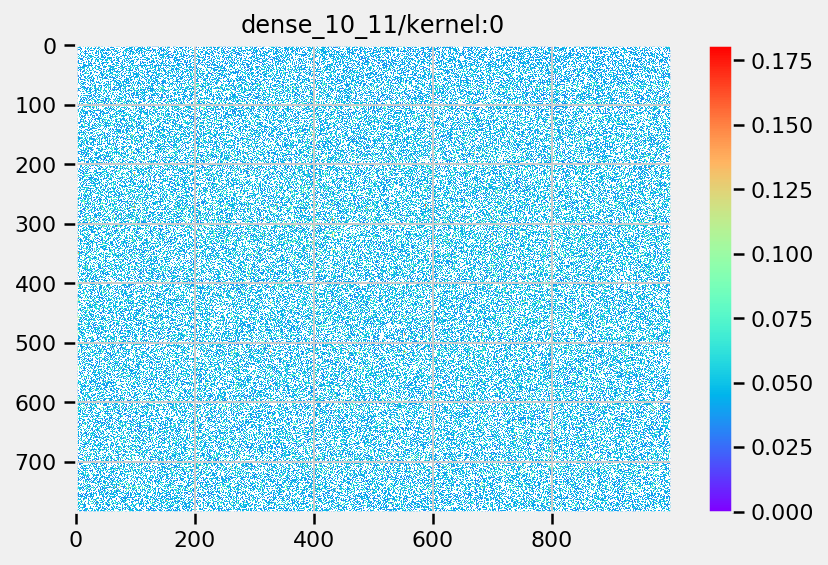

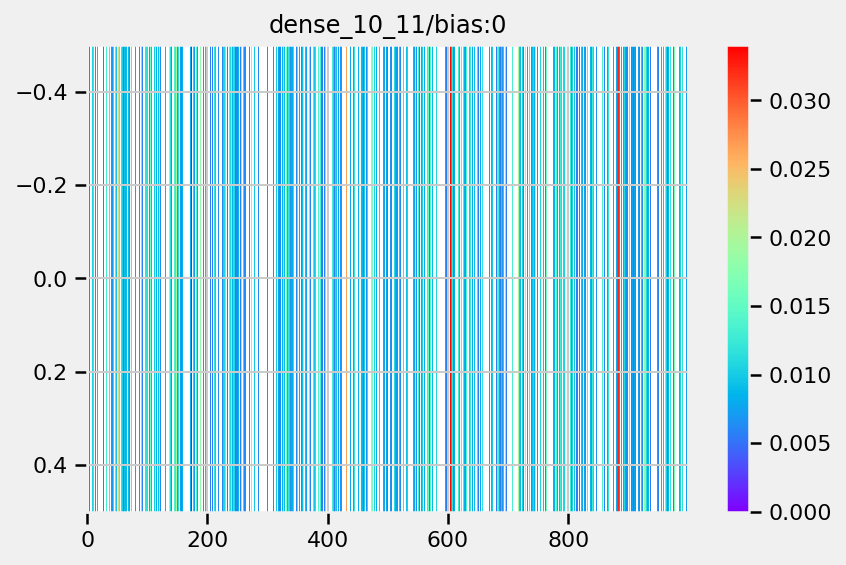

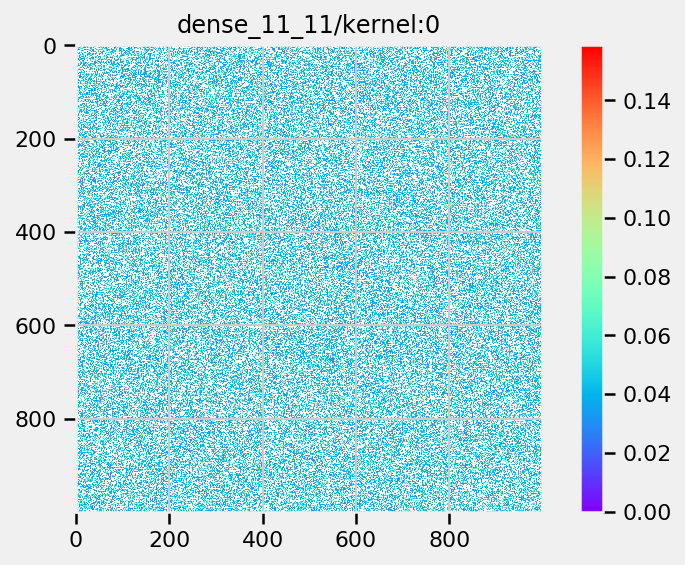

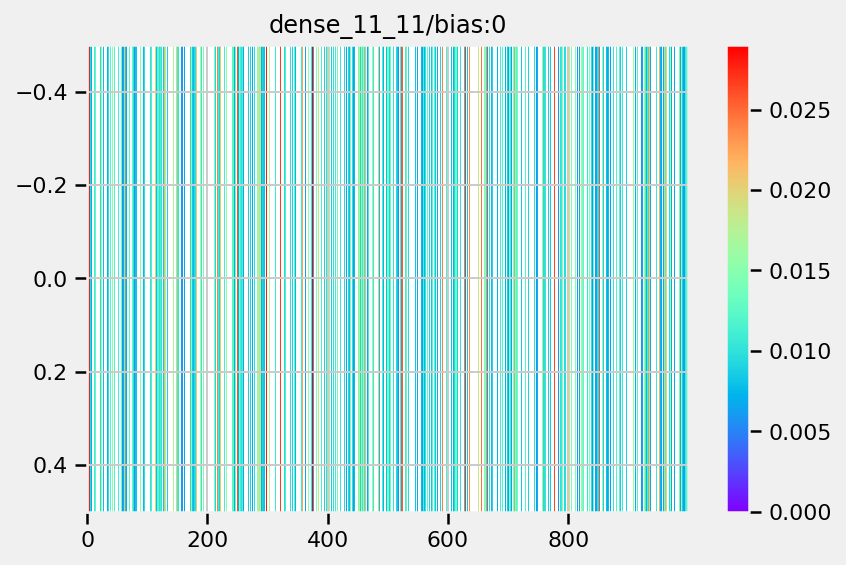

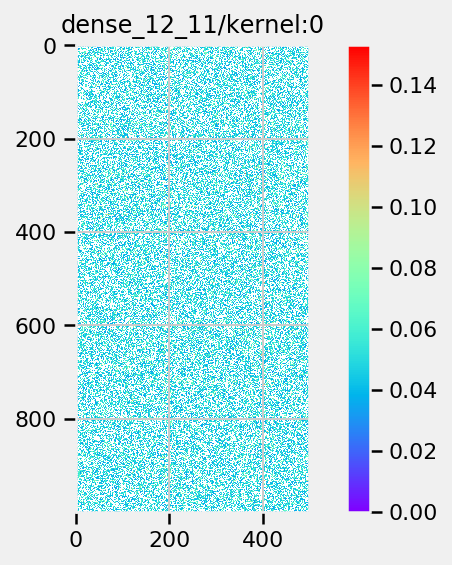

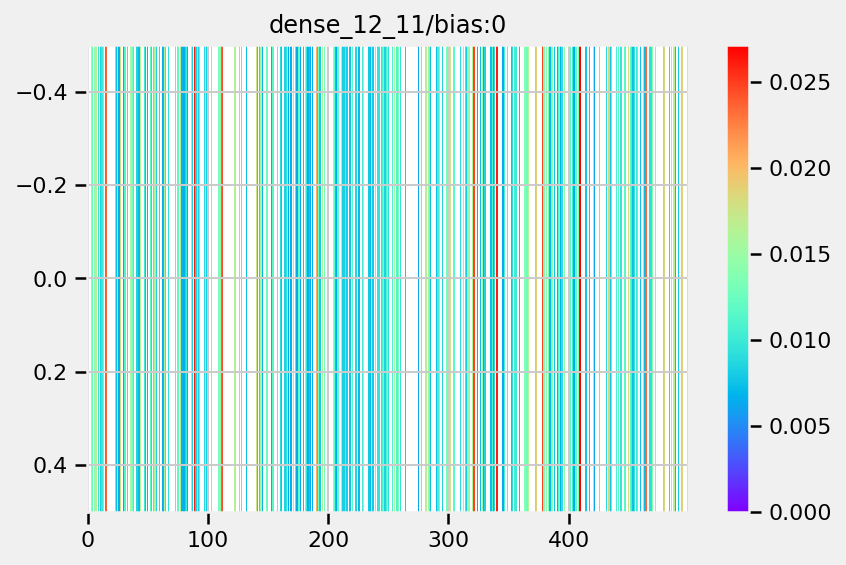

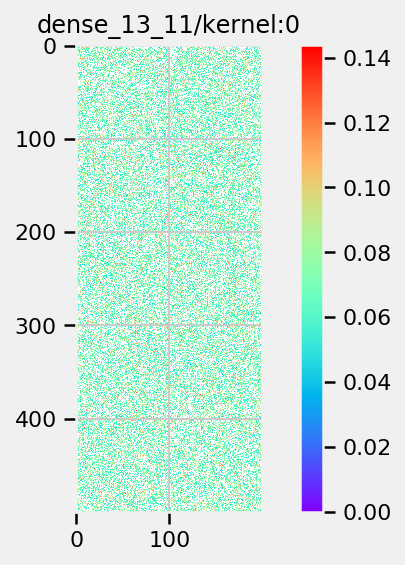

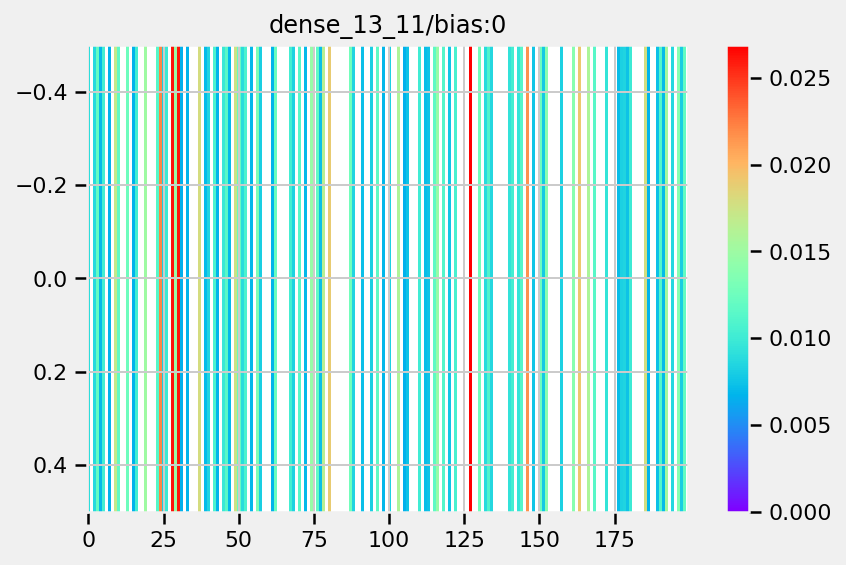

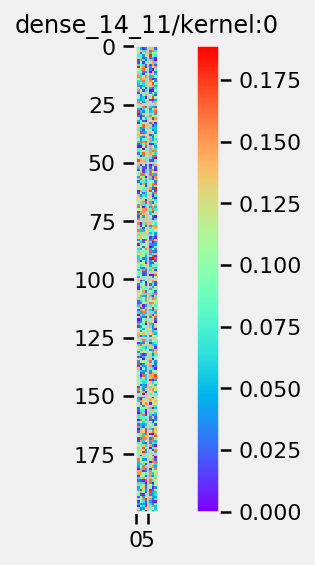

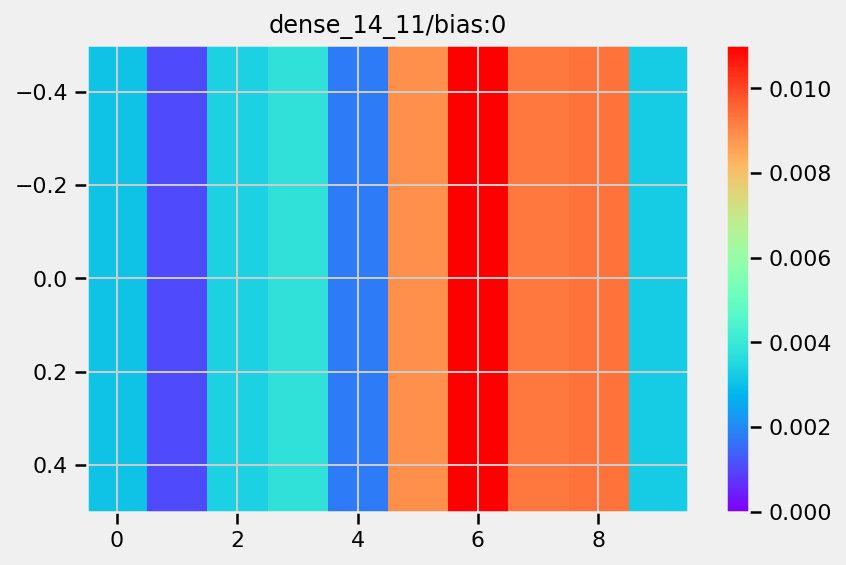

In [22]:
#@title Dense Layer visualization { run: "auto" }

#@markdown In Google Colab, this file becomes interactive, and you can select the sparse model you want to retrieve.
#@markdown 
#@markdown All weights with values of `0.0` will be color-coded weight. 1D Bias layers will be auto-scaled to the dimensions of the 2D plots.
#@markdown 
#@markdown Which dataset?
dataset = 'mnist' #@param ['mnist', 'fmnist']
#@markdown k sparsity
sparsity = "0.5" #@param ['0.0', '0.25', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.97', '0.99']
#@markdown Pruning method.
pruning = 'weight' #@param ['unit', 'weight']

sparse_model = load_model('models/sparse_{}-model_k-{}_{}-pruned.h5'.format(dataset, sparsity, pruning))

visualize_model_weights(sparse_model)

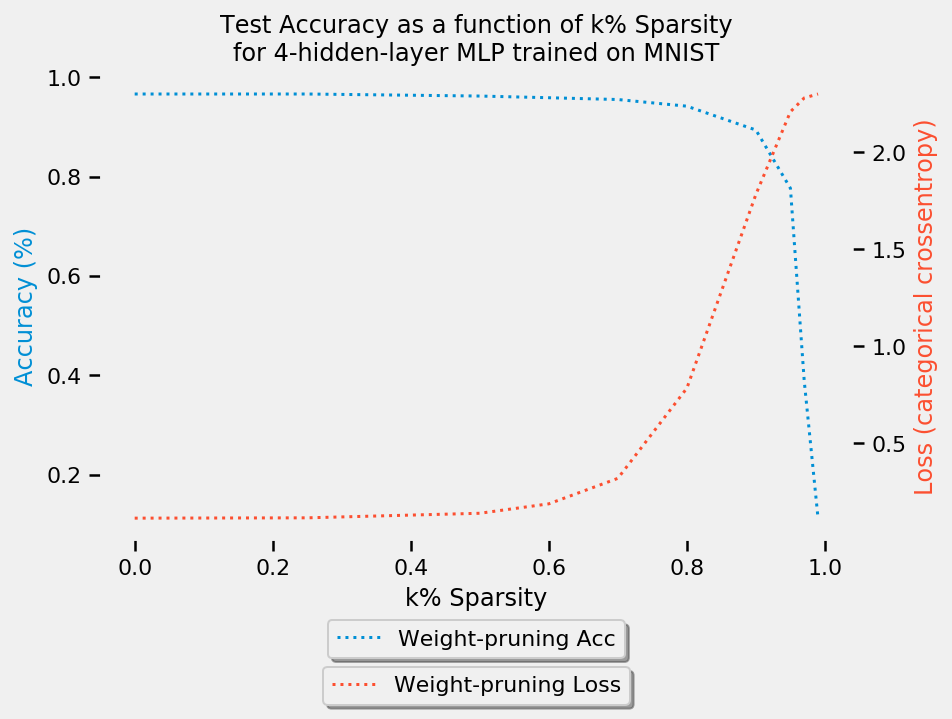

In [23]:
# MNIST 데이터셋 성능 Visualization
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor 4-hidden-layer MLP trained on MNIST')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_acc_weight'].values,
         '#008fd5', linestyle=':', label='Weight-pruning Acc')
# ax1.plot(sparsity_summary['k_sparsity'].values,
#          sparsity_summary['mnist_acc_unit'].values,
#          '#008fd5', linestyle='-', label='Unit-pruning Acc')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['mnist_loss_weight'].values,
         '#fc4f30', linestyle=':', label='Weight-pruning Loss')
# ax2.plot(sparsity_summary['k_sparsity'].values,
#          sparsity_summary['mnist_loss_unit'].values,
#          '#fc4f30', linestyle='-', label='Unit-pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('images/MNIST_sparsity_comparisons.png')

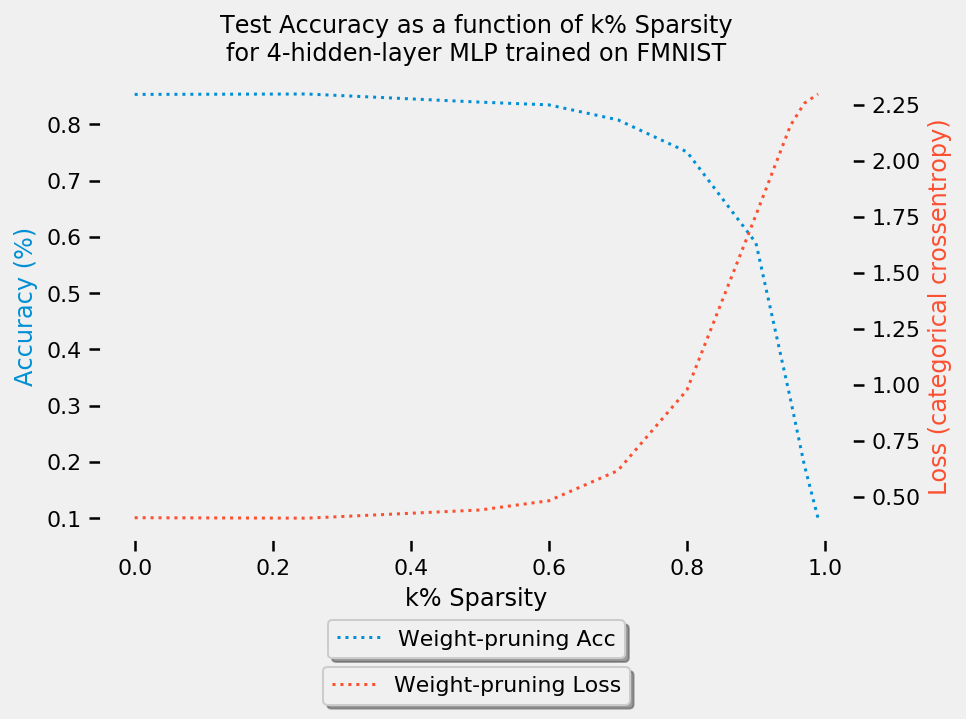

In [24]:
# Fashion-MNIST 데이터셋 성능 Visualization
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
plt.grid(b=None)
ax2 = ax1.twinx()
plt.grid(b=None)
plt.title('Test Accuracy as a function of k% Sparsity\nfor 4-hidden-layer MLP trained on FMNIST')
ax1.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_acc_weight'].values,
         '#008fd5', linestyle=':', label='Weight-pruning Acc')
# ax1.plot(sparsity_summary['k_sparsity'].values,
#          sparsity_summary['fmnist_acc_unit'].values,
#          '#008fd5', linestyle='-', label='Unit-pruning Acc')
ax2.plot(sparsity_summary['k_sparsity'].values,
         sparsity_summary['fmnist_loss_weight'].values,
         '#fc4f30', linestyle=':', label='Weight-pruning Loss')
# ax2.plot(sparsity_summary['k_sparsity'].values,
#          sparsity_summary['fmnist_loss_unit'].values,
#          '#fc4f30', linestyle='-', label='Unit-pruning Loss')

ax1.set_ylabel('Accuracy (%)', color='#008fd5')
ax2.set_ylabel('Loss (categorical crossentropy)', color='#fc4f30')
ax1.set_xlabel('k% Sparsity')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2);
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), shadow=True, ncol=2);
plt.savefig('images/FMNIST_sparsity_comparisons.png')